In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy

## Convolution

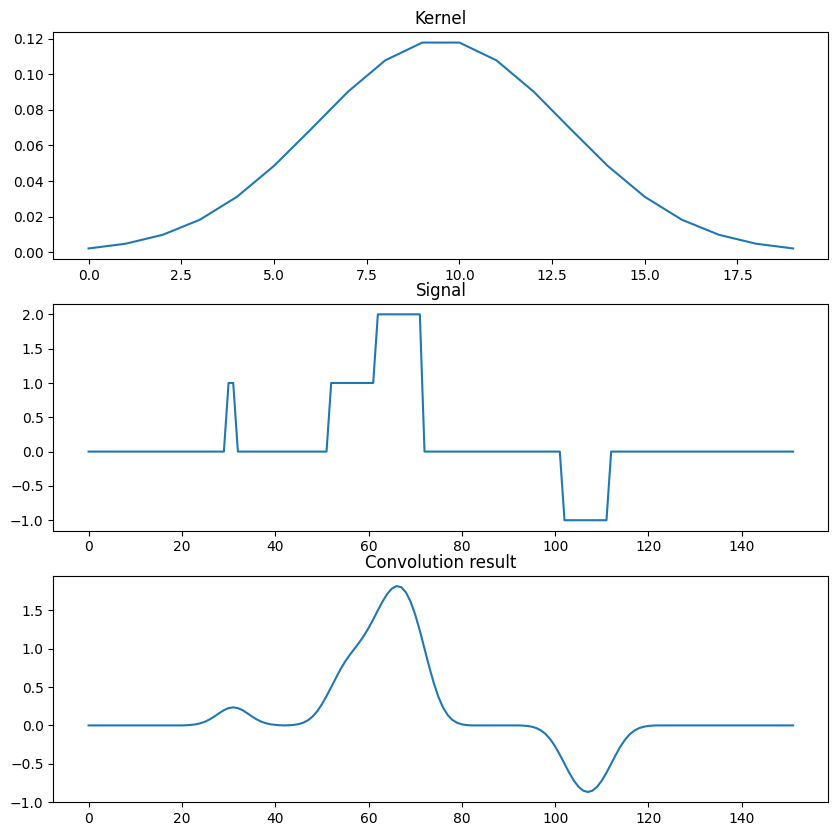

In [2]:
# Step 1: Create the signal

signal = np.concat((
    np.zeros(30),       # 30 elements of zeros
    np.ones(2),         # 2 elements of ones
    np.zeros(20),       # 20 elements of zeros
    np.ones(10),        # 10 elements of ones
    2*np.ones(10),      # 10 elements of twos (2 * ones)
    np.zeros(30),       # 30 elements of zeros
    -np.ones(10),       # 10 elements of negative ones
    np.zeros(40)        # 40 elements of zeros
), axis=0)  # Concatenate all of these arrays into a single signal

# Step 2: Create the kernel for convolution

# Generate a kernel using a Gaussian function
kernel = np.exp(-(np.linspace(-2, 2, 20)**2))  # linspace creates 20 evenly spaced values between -2 and 2
kernel = kernel / sum(kernel)  # Normalize the kernel by dividing by the sum of all its elements

# Step 3: Plot the kernel, signal, and the convolution result

plt.figure(figsize=(10,10))  # Create a figure with size 10x10 inches

# Subplot 1: Plot the kernel
plt.subplot(311)  # First subplot (3 rows, 1 column, first plot)
plt.plot(kernel)  # Plot the kernel
plt.title("Kernel")  # Set title of the first plot as 'Kernel'

# Subplot 2: Plot the original signal
plt.subplot(312)  # Second subplot (3 rows, 1 column, second plot)
plt.plot(signal)  # Plot the signal
plt.title("Signal")  # Set title of the second plot as 'Signal'

# Subplot 3: Plot the convolution result
plt.subplot(313)  # Third subplot (3 rows, 1 column, third plot)
# Convolve the signal with the kernel using 'same' mode, which returns an output the same size as the input signal
plt.plot(np.convolve(signal, kernel, "same"))  
plt.title("Convolution result")  # Set title of the third plot as 'Convolution result'

# Display the figure
plt.show()

## Convolutional Theorem

In [3]:
# Step 1: Define the signal and kernel
signal = np.zeros(20)            # Initialize a signal with 20 elements, all set to zero
signal[8:15] = 1                 # Set the elements between index 8 and 14 (inclusive) to 1 (forming a pulse)

kernel = [1, .8, .6, .4, .2]     # Define the kernel for convolution (a decreasing sequence)

# Step 2: Prepare parameters for the convolution

nSign = len(signal)              # Length of the signal (20)
nKern = len(kernel)              # Length of the kernel (5)
nConv = nSign + nKern - 1        # Length of the convolution result (24), based on signal and kernel lengths

half_kern = int(np.floor(nKern / 2))  # Compute half the kernel size (used for padding and alignment)

kflip = kernel[::-1]             # Flip the kernel (this is necessary for convolution)

# Step 3: Prepare the padded signal

# Pad the signal with zeros on both sides, to ensure we can apply the kernel to the entire signal
data4conv = np.concatenate((np.zeros(half_kern), signal, np.zeros(half_kern)), axis=0)

# Step 4: Convolution using the time-domain method

conv_res = np.zeros(nConv)       # Initialize the convolution result array with zeros

# Perform the convolution by sliding the flipped kernel over the signal
for i in range(half_kern, nConv - half_kern):
    tempdata = data4conv[i - half_kern:i + half_kern + 1]  # Extract the segment of the padded signal
    conv_res[i] = np.sum(tempdata * kflip)                 # Multiply element-wise and sum, then store in result

# Remove the extra padding to obtain the final convolution result
conv_res = conv_res[half_kern+1:-1-half_kern]  

# Step 5: Fast Fourier Transform (FFT) method for convolution

# Compute the FFT of the signal and kernel, both zero-padded to the length of the convolution result (nConv)
signalX = scipy.fftpack.fft(signal, nConv)
kernelX = scipy.fftpack.fft(kernel, nConv)

# Multiply the FFT of the signal and kernel element-wise (convolution in the frequency domain)
sigXkern = signalX * kernelX

# Perform the inverse FFT to get the convolution result in the time domain
conv_resFFT = np.real(scipy.fftpack.ifft(sigXkern))

# Remove the extra padding (same as done with the time-domain convolution)
conv_resFFT = conv_resFFT[half_kern+1:-half_kern]

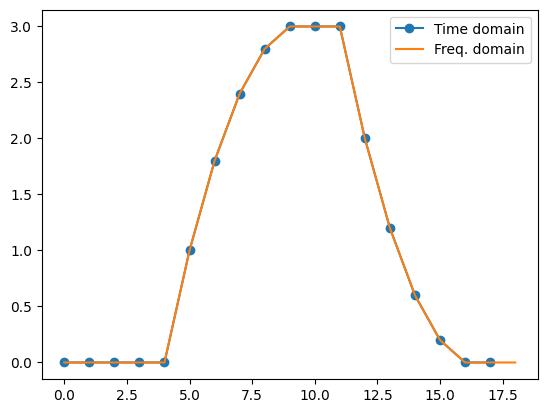

In [4]:
# Step 6: Plot the convolution results
plt.plot(conv_res, 'o-', label='Time domain')  # Plot the time-domain convolution result with circle markers ('o-')
plt.plot(conv_resFFT, '-', label='Freq. domain')  # Plot the frequency-domain convolution result as a line ('-')
plt.legend()  # Add a legend to differentiate between the two plots
plt.show()  # Display the plot

## Convolution with frequency-domain Gaussian (narrowband filter)

In [5]:
# Step 1: Set the sampling rate and time vector

srate = 1000                      # Sampling rate of 1000 Hz
time = np.arange(0, 3, 1/srate)   # Time vector from 0 to 3 seconds with steps of 1/srate (3 seconds of data)
n = len(time)                     # Number of data points in the time vector
p = 15                            # Number of random points used for the amplitude envelope

# Step 2: Generate the signal

noiseamp = 5                      # Amplitude of the noise

# Create a smooth amplitude modulation envelope using linear interpolation
ampl = np.interp(np.linspace(0, p, n), np.arange(0, p), np.random.rand(p) * 30)

# Generate random noise
noise = noiseamp * np.random.randn(n)

# Combine the amplitude envelope and noise to create the signal
signal1 = ampl + noise

# Step 3: Remove the DC offset (mean) from the signal

signal1 = signal1 - np.mean(signal1)

# Step 4: Define the filter parameters for frequency-domain convolution

peakf = 11                        # Peak frequency (11 Hz)
fwhm = 5.2                        # Full width at half maximum (FWHM) for the Gaussian filter

# Generate frequency vector (Hz) corresponding to the signal length
hz = np.linspace(0, srate, n)

# Step 5: Create a Gaussian filter in the frequency domain

s = fwhm * (2 * np.pi - 1) / (4 * np.pi)  # Standard deviation of the Gaussian (based on FWHM)
x = hz - peakf                            # Shift the frequency axis by the peak frequency
fx = np.exp(-0.5 * (x / s)**2)            # Generate the Gaussian filter

# Step 6: Perform convolution in the frequency domain using FFT

# Compute the FFT of the signal
dataX = scipy.fftpack.fft(signal1)

# Multiply the FFT of the signal by the Gaussian filter (element-wise multiplication)
convres = 2 * np.real(scipy.fftpack.ifft(dataX * fx))

# Step 7: Create a frequency vector for plotting or analysis
hz = np.linspace(0, srate, n)

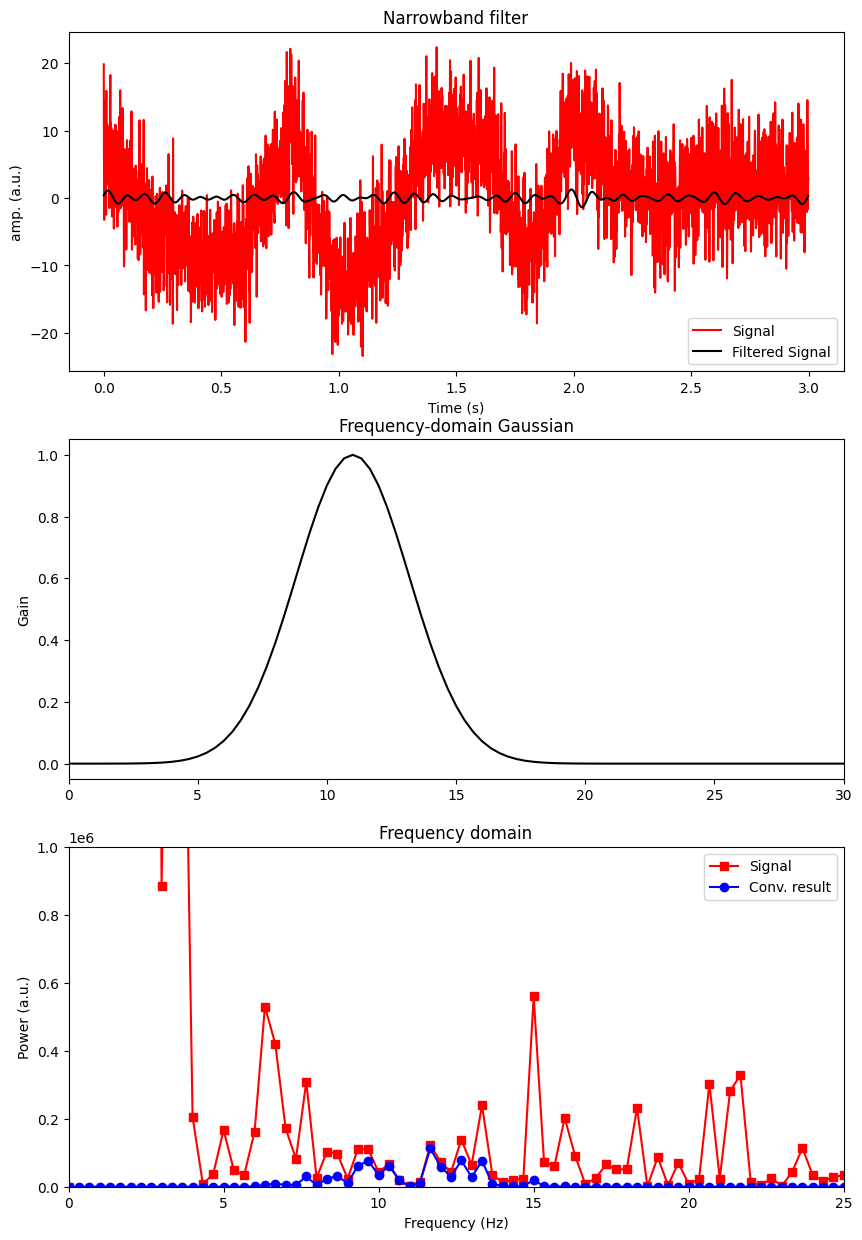

In [7]:
# Create a figure with a size of 10x10 inches
plt.figure(figsize=(10,15))

# Plot 1: Original Signal vs. Filtered Signal (Time Domain)
plt.subplot(311)  # First subplot (3 rows, 1 column, first plot)
plt.plot(time, signal1, 'r', label='Signal')  # Plot the original signal in red
plt.plot(time, convres, 'k', label='Filtered Signal')  # Plot the filtered signal in black
plt.xlabel('Time (s)')  # Label for x-axis (time in seconds)
plt.ylabel('amp. (a.u.)')  # Label for y-axis (amplitude in arbitrary units)
plt.legend()  # Add a legend to differentiate between the original and filtered signals
plt.title('Narrowband filter')  # Title for the plot

# Plot 2: Frequency-Domain Gaussian Filter
plt.subplot(312)  # Second subplot (3 rows, 1 column, second plot)
plt.plot(hz, fx, 'k')  # Plot the Gaussian filter in the frequency domain
plt.xlim([0, 30])  # Set the x-axis limits from 0 to 30 Hz
plt.ylabel('Gain')  # Label for y-axis (gain of the filter)
plt.title('Frequency-domain Gaussian')  # Title for the plot

# Plot 3: Power Spectrum of the Original Signal vs. Filtered Signal (Frequency Domain)
plt.subplot(313)  # Third subplot (3 rows, 1 column, third plot)
# Plot the power spectrum of the original signal in red (squares and line)
plt.plot(hz, np.abs(dataX)**2, 'rs-', label='Signal')
# Plot the power spectrum of the filtered (convolved) result in blue (circles and line)
plt.plot(hz, np.abs(dataX*fx)**2, 'bo-', label='Conv. result')
plt.xlabel('Frequency (Hz)')  # Label for x-axis (frequency in Hz)
plt.ylabel('Power (a.u.)')  # Label for y-axis (power in arbitrary units)
plt.legend()  # Add a legend to differentiate between the signal and convolved result
plt.title('Frequency domain')  # Title for the plot
plt.xlim([0, 25])  # Set the x-axis limits from 0 to 25 Hz
plt.ylim([0, 1e6])  # Set the y-axis limits to restrict the plot's range for better visualization
plt.show()  # Display the figure